In [1]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 

import statsmodels.api as sm
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import scipy.stats as stats

import math

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Scrub - Converting data types


In [4]:

#convert column name ['date'] from object to datetime 

#might be cool to create a function that takes any column date and converts it 

df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [5]:
# Obvious issue with sqft_basement due to columns
#First attempt to convert failed due to ? marks so we need to remove them 

df['sqft_basement'].nunique()

304

In [6]:

#replacing all ? with 0's - major assumption that requires data enrichment to correct
#

df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x==
                                             '?' else x)

df['sqft_basement'] = df['sqft_basement'].astype(float)

In [7]:
# Scrub - Treating Null values


In [8]:
# Identify null values 

df.isna().sum()


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [9]:
# Look for columns where all 3 are missing 
#This isnt a huge % of the data so we allow it 

print('Number Missing All Three:',
     len(df[(df.waterfront.isnull())
           & (df.view.isnull())
           & (df.yr_renovated.isnull())]))

Number Missing All Three: 2


In [11]:

#Repeat the same process for view which indicates how many times a house has been viewed

#We replaced all views with a median value, its safe to assume houses on the market in these areas are quite popular and viewed 
median = df['view'].median()
df['view'] = df['view'].fillna(value=median)#Waterfront 0 = No waterfront, 1=Waterfront 

#Making all nulls 0 indicating no waterfront 

df['waterfront'].isna().sum()

df['waterfront'] = df['waterfront'].fillna(0)

In [12]:
# Assuming renovation nulls are the same as renovation yr_built 

df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [13]:
df.isna().sum()


id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Major assumptions of scrubbing
Waterfront - nulls = 0 and 1 means on the waterfront, replaced all nulls with 0

Filled view with median value, assuming all houses are viewed or in demand (justification is this is a major area with lots of people moving there)

if there is no yr_renovated, fill with most recent year built

In [14]:
#dropped all duplicates for id 
#inplace = True changes the dataframe permanently

df.drop_duplicates(subset=['id'], inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C7B363B88>,
      dtype=object)

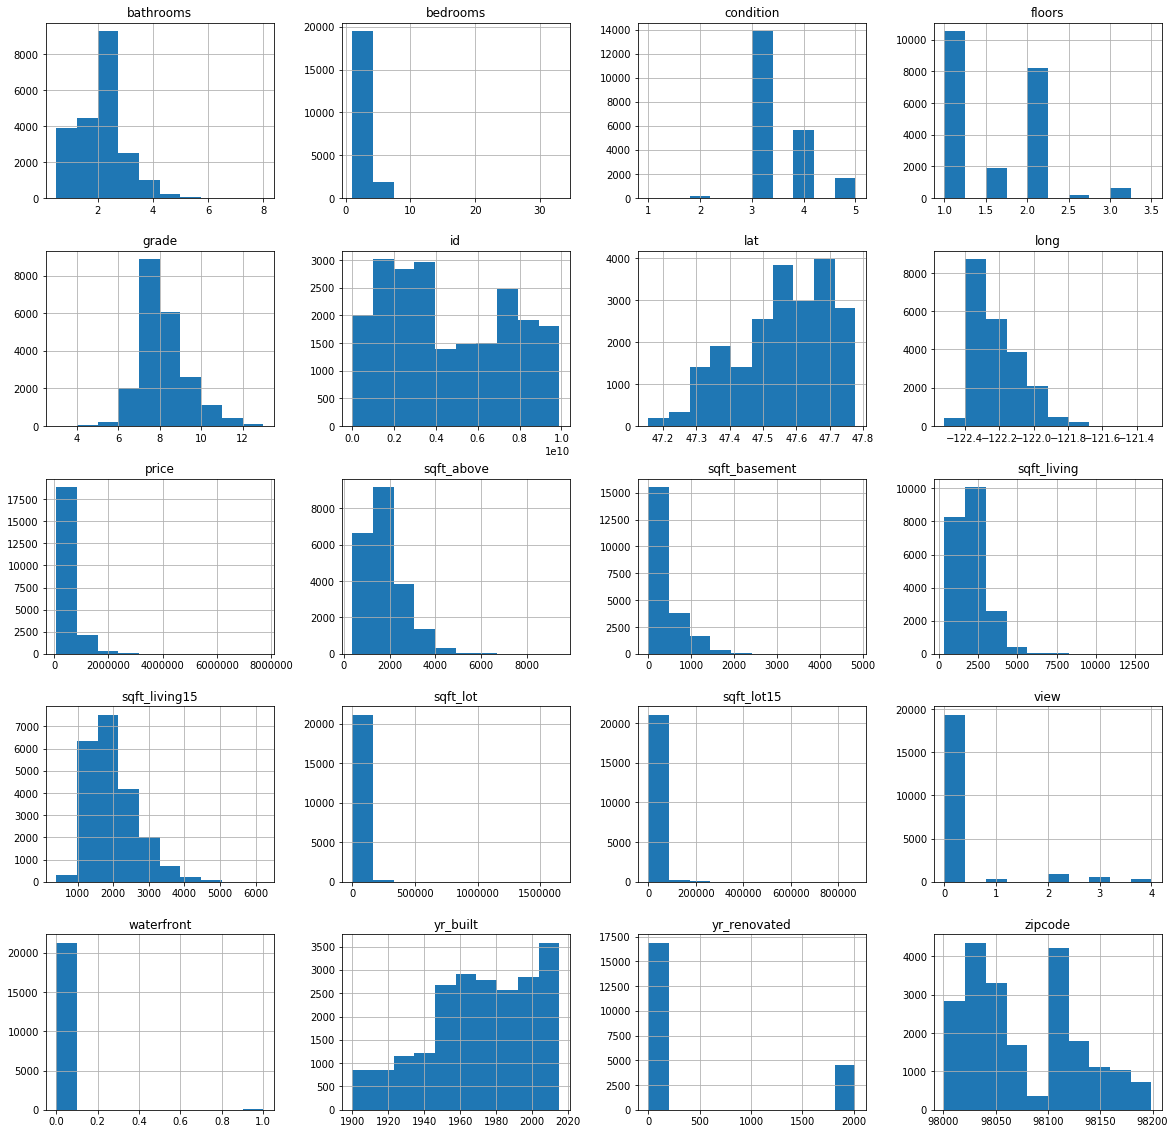

In [15]:
df.hist(figsize=(20,20))

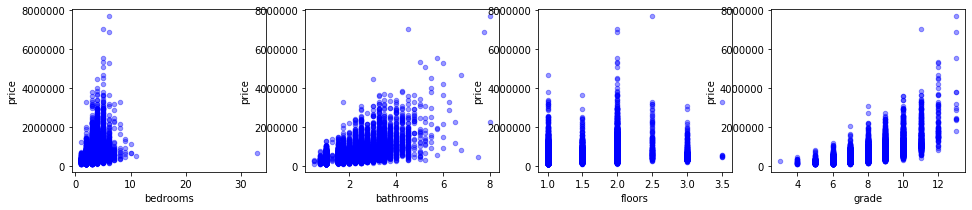

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

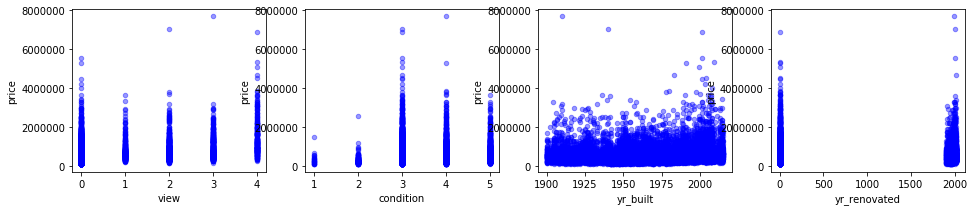

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['view', 'condition', 'yr_built', 'yr_renovated'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Checking for Linear Relationships to find the best data


In [18]:
#sqft_living 

indexNames = df[df['sqft_living'] >= 5000 ].index
df.drop(indexNames , inplace=True)

# sqft_above 

indexNames = df[df['sqft_above'] >= 4500 ].index
df.drop(indexNames , inplace=True)

#sqft_basement 

indexNames = df[df['sqft_basement'] >= 2000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_lot outliers

indexNames = df[df['sqft_lot'] >= 100000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers

indexNames = df[df['sqft_living15'] >= 4500 ].index
df.drop(indexNames , inplace=True)


# dropping sqft_lot15 outliers

indexNames = df[df['sqft_lot15'] >= 100000 ].index
df.drop(indexNames , inplace=True)


# dropping grade outliers
indexNames = df[df['grade'] == 3 ].index
df.drop(indexNames , inplace=True)

indexNames = df[df['grade'] == 13 ].index
df.drop(indexNames , inplace=True)

# dropping bedroom outliers over 8 rooms
indexNames = df[df['bedrooms'] >= 8 ].index
df.drop(indexNames , inplace=True)

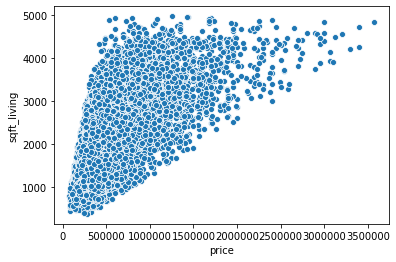

In [19]:
sns.scatterplot(x='price', y='sqft_living', data=df)

(array([ 576., 3342., 4967., 4445., 3178., 1956., 1163.,  579.,  291.,
          71.]),
 array([ 370.,  831., 1292., 1753., 2214., 2675., 3136., 3597., 4058.,
        4519., 4980.]),
 <a list of 10 Patch objects>)

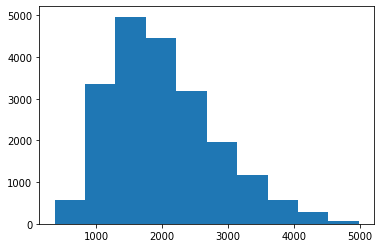

In [20]:
# Histogram of variable 

plt.hist(df['sqft_living'])

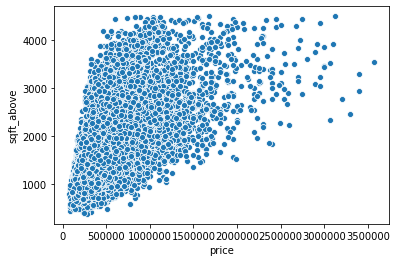

In [21]:
sns.scatterplot(x='price', y='sqft_above', data=df)


(array([ 624., 4669., 5743., 3548., 2268., 1708., 1045.,  565.,  272.,
         126.]),
 array([ 370.,  782., 1194., 1606., 2018., 2430., 2842., 3254., 3666.,
        4078., 4490.]),
 <a list of 10 Patch objects>)

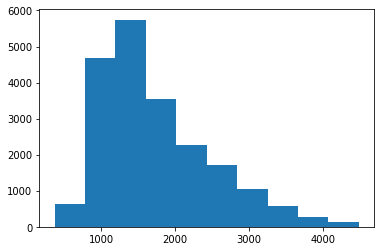

In [22]:
plt.hist(df['sqft_above'])


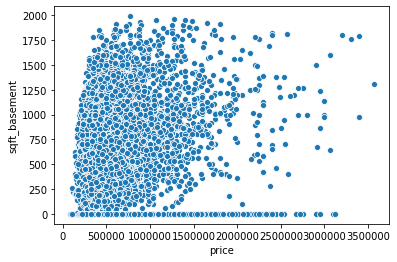

In [23]:
sns.scatterplot(x='price', y='sqft_basement', data=df)


(array([13111.,  1164.,  1558.,  1602.,  1413.,   875.,   480.,   226.,
           93.,    46.]),
 array([   0.,  199.,  398.,  597.,  796.,  995., 1194., 1393., 1592.,
        1791., 1990.]),
 <a list of 10 Patch objects>)

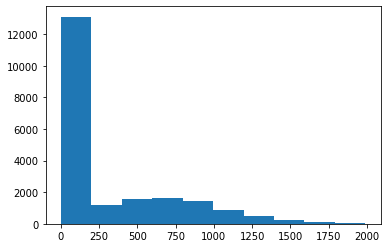

In [24]:
plt.hist(df['sqft_basement'])


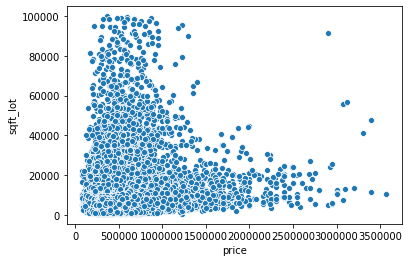

In [25]:
sns.scatterplot(x='price', y='sqft_lot', data=df)

(array([15796.,  3180.,   525.,   443.,   287.,   137.,    73.,    50.,
           39.,    38.]),
 array([  520. , 10459.6, 20399.2, 30338.8, 40278.4, 50218. , 60157.6,
        70097.2, 80036.8, 89976.4, 99916. ]),
 <a list of 10 Patch objects>)

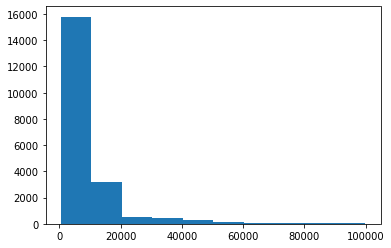

In [26]:
plt.hist(df['sqft_lot'])


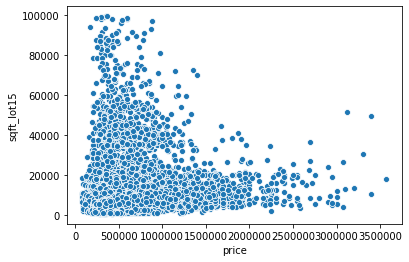

In [27]:
sns.scatterplot(x='price', y='sqft_lot15', data=df)

(array([16528.,  2767.,   383.,   437.,   222.,   109.,    45.,    29.,
           26.,    22.]),
 array([  651. , 10517.5, 20384. , 30250.5, 40117. , 49983.5, 59850. ,
        69716.5, 79583. , 89449.5, 99316. ]),
 <a list of 10 Patch objects>)

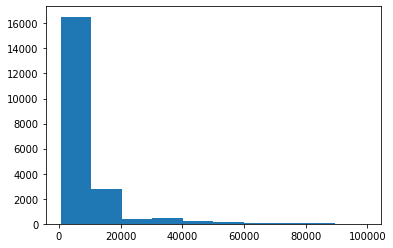

In [28]:
plt.hist(df['sqft_lot15'])

Clearly need to remove outliers and perform a log function


In [29]:
df_num = df[['price', 'bedrooms', 'bathrooms','floors', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']].copy()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C0160AE08>,
      dtype=object)

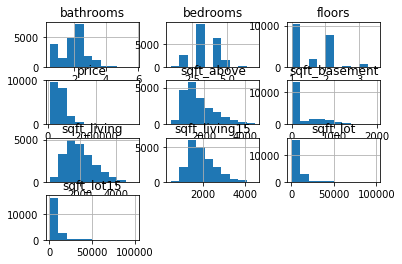

In [30]:
df_num.hist()


In [31]:
#created a logged numerical df 

df_sqft_logs = pd.DataFrame([])
df_sqft_logs = df_num

In [32]:
df_sqft_logs['sqft_living_log'] = np.log(df_sqft_logs['sqft_living'])
df_sqft_logs['sqft_above_log'] = np.log(df_sqft_logs['sqft_above'])
df_sqft_logs['sqft_lot_log'] = np.log(df_sqft_logs['sqft_lot'])
df_sqft_logs['sqft_basement_log'] = np.log(df_sqft_logs['sqft_basement'])
df_sqft_logs['sqft_living15_log'] = np.log(df_sqft_logs['sqft_living15'])
df_sqft_logs['sqft_lot15_log'] = np.log(df_sqft_logs['sqft_lot15'])
df_sqft_logs['bathrooms'] = np.log(df_sqft_logs['bathrooms'])
df_sqft_logs['bedrooms'] = np.log(df_sqft_logs['bedrooms'])
df_sqft_logs['floors'] = np.log(df_sqft_logs['floors'])

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
headers = list(df_sqft_logs)

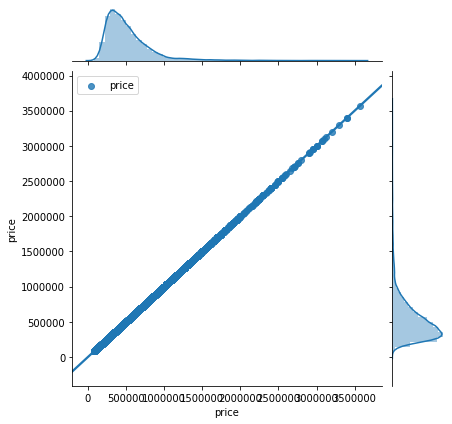

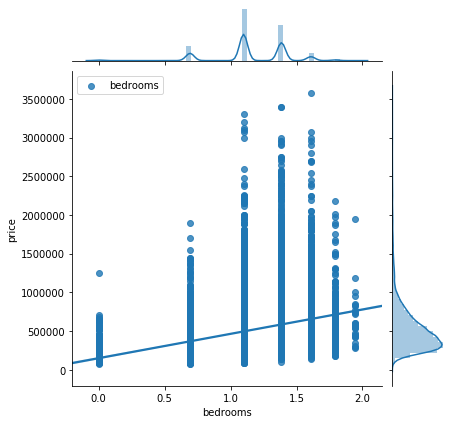

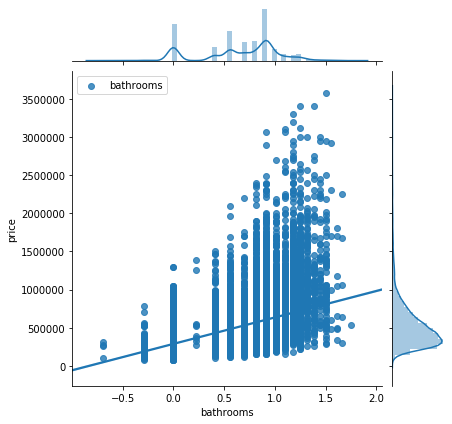

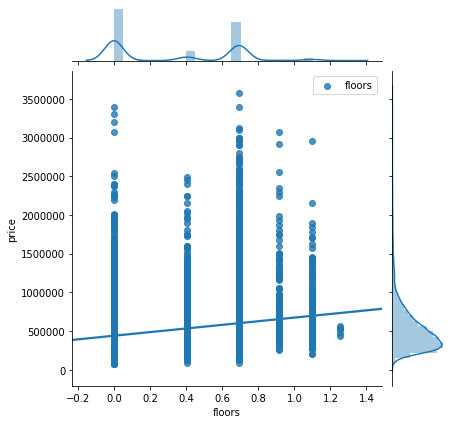

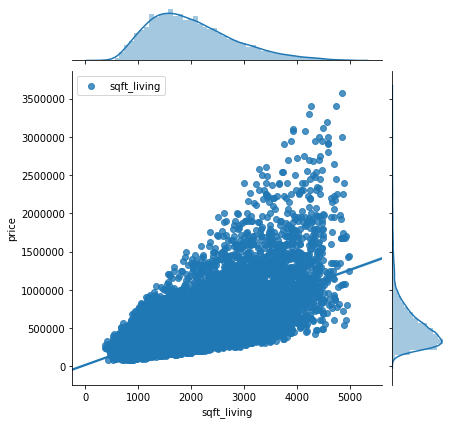

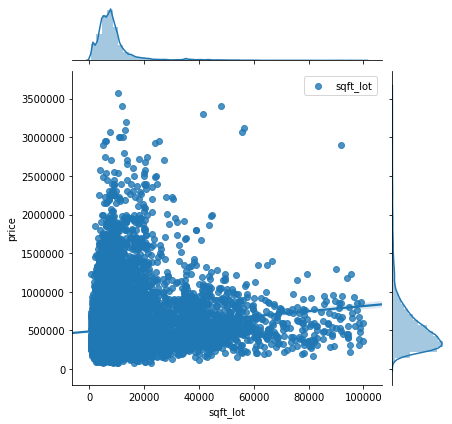

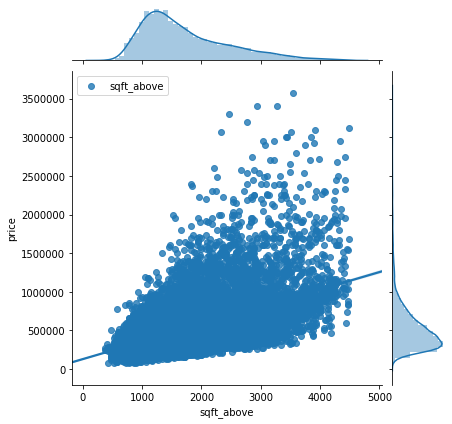

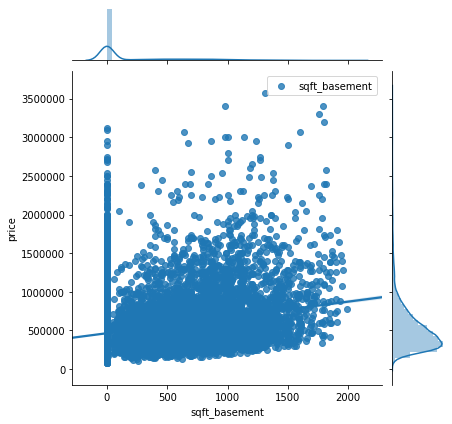

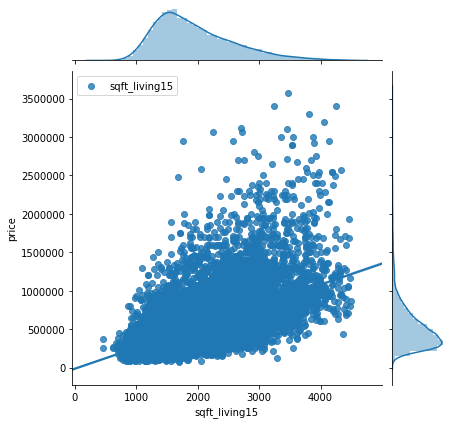

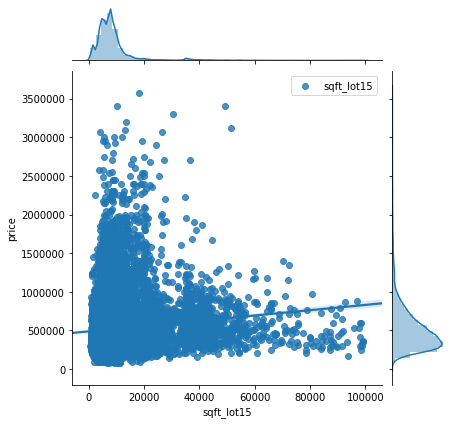

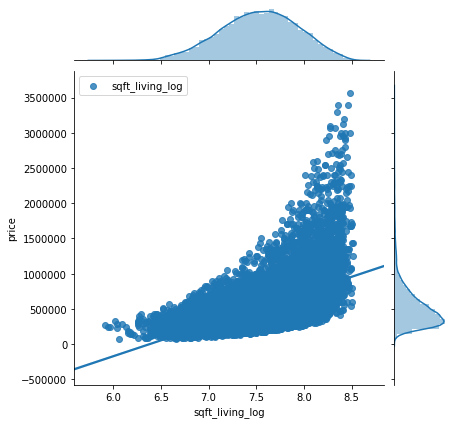

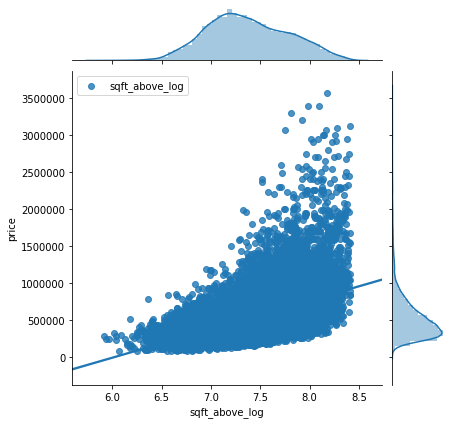

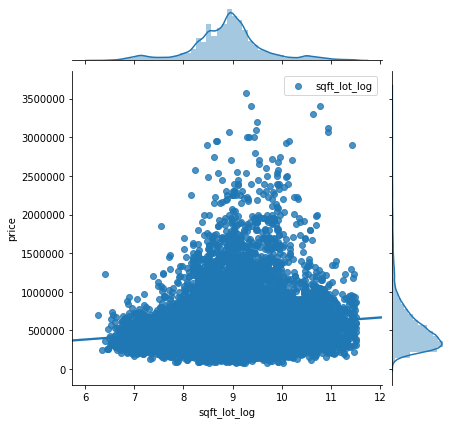

C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:39: RuntimeWarning: invalid value encountered in double_scalars
  return int(np.ceil((a.max() - a.min()) / h))


ValueError: cannot convert float NaN to integer

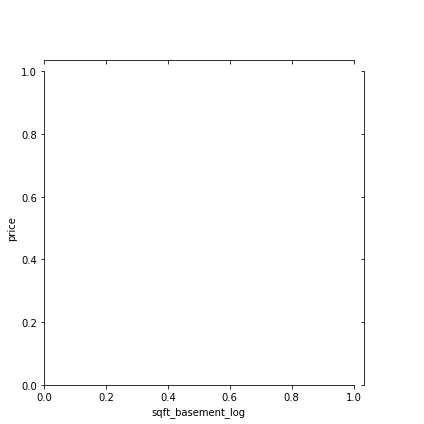

In [34]:

for column in headers:
    sns.jointplot(x=column, y='price',
                 data=df_sqft_logs,
                 kind='reg',
                 label=column,
                 )
    plt.legend()
    plt.show()

In [35]:
# Encoding Categorical Variables

In [36]:

df_cat = df[['view', 'condition', 'waterfront','grade', 'yr_built', 'yr_renovated']].copy()

In [37]:
df_cat['condition'] = df_cat['condition'].astype("int")
df_cat['waterfront'] =  df_cat['waterfront'].astype("int")

In [38]:
df_cat.columns = df_cat.columns.astype("str")

In [39]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20568 entries, 0 to 21596
Data columns (total 6 columns):
view            20568 non-null float64
condition       20568 non-null int32
waterfront      20568 non-null int32
grade           20568 non-null int64
yr_built        20568 non-null int64
yr_renovated    20568 non-null float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 964.1 KB


In [ ]:
df_cat = pd.get_dummies(df_cat, drop_first=True) #pd
df_cat.info()

# Combine categorical and numerical data


In [40]:
df_combo = pd.concat([df_sqft_logs, df_cat], axis=1)
df_combo.head()


,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,...,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,1.098612,0.000000,0.000000,1180,5650,1180,0.0,1340,5650,...,8.639411,-inf,7.200425,8.639411,0.0,3,0,7,1955,0.0
1,538000.0,1.098612,0.810930,0.693147,2570,7242,2170,400.0,1690,7639,...,8.887653,5.991465,7.432484,8.941022,0.0,3,0,7,1951,1991.0
2,180000.0,0.693147,0.000000,0.000000,770,10000,770,0.0,2720,8062,...,9.210340,-inf,7.908387,8.994917,0.0,3,0,6,1933,1933.0
3,604000.0,1.386294,1.098612,0.000000,1960,5000,1050,910.0,1360,5000,...,8.517193,6.813445,7.215240,8.517193,0.0,5,0,7,1965,0.0
4,510000.0,1.098612,0.693147,0.000000,1680,8080,1680,0.0,1800,7503,...,8.997147,-inf,7.495542,8.923058,0.0,3,0,8,1987,0.0


In [41]:
for cat_names in df_combo.iloc[:,11:].columns:
    df_combo[cat_names] = df_combo[cat_names].astype('category')


In [42]:
# OLS Regression

#It didnt seem to work!

import statsmodels.api as sm
import statsmodels.formula.api as smf

col_names = df_combo.describe().columns[1:11] #What does this?

results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p_value ']] #creating an array of results we care about

for idx, val in enumerate(col_names):
    print('price~' + val)
    f = 'price~' + val
    model = smf.ols(formula=f, data=df_combo).fit()
    X_new = pd.DataFrame({val: [df_combo[val].min(), df_combo[val].max()]});
    preds = model.predict(X_new)
    results.append({val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]})

    print(results[idx+1])
    print(model.summary())

price~bedrooms
{0.08169228554504182, 0.0, 314627.2065113989, 'bedrooms', 149692.460885135}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1830.
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:17:49   Log-Likelihood:            -2.8818e+05
No. Observations:               20568   AIC:                         5.764e+05
Df Residuals:                   20566   BIC:                         5.764e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

strong multicollinearity or other numerical problems.
price~sqft_basement
{0.076167584112109, 'sqft_basement', 0.0, 204.5249403845112, 462427.8411296069}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1696.
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:17:49   Log-Likelihood:            -2.8824e+05
No. Observations:               20568   AIC:                         5.765e+05
Df Residuals:                   20566   BIC:                         5.765e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t

In [43]:
df_num.corr()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log
price,1.000000,0.285819,0.434301,0.268896,0.649537,0.114020,0.544432,0.275985,0.571458,0.103520,0.593556,0.515154,0.117244,0.270311,0.541229,0.109716
bedrooms,0.285819,1.000000,0.523089,0.204071,0.598574,0.112931,0.495838,0.261215,0.403380,0.105641,0.650176,0.544592,0.227758,0.442750,0.422781,0.205498
bathrooms,0.434301,0.523089,1.000000,0.508275,0.706456,0.073162,0.626925,0.236643,0.534279,0.073177,0.746485,0.665089,0.034520,0.334547,0.554281,0.034638
floors,0.268896,0.204071,0.508275,1.000000,0.380924,-0.092294,0.569117,-0.277605,0.296752,-0.086923,0.384446,0.578616,-0.289614,-0.215417,0.290771,-0.274252
sqft_living,0.649537,0.598574,0.706456,0.380924,1.000000,0.242852,0.856707,0.389845,0.752808,0.227849,0.969870,0.843478,0.314090,0.629120,0.738669,0.292472
sqft_lot,0.114020,0.112931,0.073162,-0.092294,0.242852,1.000000,0.232490,0.053026,0.286167,0.834525,0.227070,0.223003,0.814608,0.221631,0.278830,0.730953
sqft_above,0.544432,0.495838,0.626925,0.569117,0.856707,0.232490,1.000000,-0.132284,0.722420,0.225621,0.822293,0.972299,0.284036,0.250997,0.698744,0.269079
sqft_basement,0.275985,0.261215,0.236643,-0.277605,0.389845,0.053026,-0.132284,1.000000,0.159216,0.036211,0.393477,-0.108529,0.097179,0.927701,0.173710,0.082637
sqft_living15,0.571458,0.403380,0.534279,0.296752,0.752808,0.286167,0.722420,0.159216,1.000000,0.293318,0.726035,0.703390,0.360681,0.374124,0.980561,0.370726
sqft_lot15,0.103520,0.105641,0.073177,-0.086923,0.227849,0.834525,0.225621,0.036211,0.293318,1.000000,0.212985,0.215507,0.729596,0.224011,0.284551,0.820391


In [62]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [63]:
# Non encoded, assumptions of regression not met in regression below 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

In [64]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.399924,-1.492128,-1.044272,-0.405855,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.749355,-0.662603,-0.530155,-0.520003,98178,47.5112,-122.257,-0.954664,-0.399311
1,6414100192,2014-12-09,538000.0,-0.399924,0.229616,0.691343,-0.256570,0.944490,-0.076283,-0.292136,...,-0.550966,0.584910,0.303026,-0.665889,1.943098,98125,47.7210,-122.319,-0.408446,-0.184876
2,5631500400,2015-02-25,180000.0,-1.543007,-1.492128,-1.556217,0.002051,-0.905984,-0.076283,-0.292136,...,-1.462066,-1.301929,-0.662603,-1.276692,1.871345,98028,47.7379,-122.233,1.198997,-0.139272
3,2487200875,2014-12-09,604000.0,0.743160,1.262663,-0.070330,-0.466806,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.924561,1.534203,-0.190820,-0.520003,98136,47.5208,-122.393,-0.923452,-0.469388
4,1954400510,2015-02-18,510000.0,-0.399924,-0.114733,-0.419950,-0.177990,-0.905984,-0.076283,-0.292136,...,0.360134,-0.075484,-0.662603,0.555717,-0.520003,98074,47.6168,-122.045,-0.236777,-0.199538


In [65]:
from statsmodels.formula.api import ols

In [66]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2345.
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:23:28   Log-Likelihood:            -2.7879e+05
No. Observations:               20568   AIC:                         5.576e+05
Df Residuals:                   20552   BIC:                         5.577e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.186e+05   1300.411    398.770      0.000    5.16e+05    5.21e+05
bedrooms      -2.694e+04   1707.630    -15.774      0.000   -3.03e+04   -2.36e+04
bathrooms      2.919e+04   2289.422     12.748      0.000    2.47e+04    3.37e+04
sqft_living    6.846e+04   1.45e+04      4.727      0.000    4.01e+04    9.68e+04
sqft_lot      -5556.3474   2386.568     -2.328      0.020   -1.02e+04    -878.485
floors         1.991e+04   1865.803     10.671      0.000    1.63e+04    2.36e+04
waterfront     3.731e+04   1413.002     26.404      0.000    3.45e+04    4.01e+04
view           3.295e+04   1512.059     21.793      0.000       3e+04    3.59e+04
condition      1.547e+04   1427.127     10.842      0.000    1.27e+04    1.83e+04
grade          1.334e+05   2225.200     59.931      0.000    1.29e+05    1.38e+05
sqft_above      1.94e+04   1.34e+04      1.452      0.147   -6796.510    4.56e+04
sqft_basement   1.82e+04   7404.577      2.458      0.014    3689.067    3.27e+04
yr_built      -1.004e+05   1777.829    -56.466      0.000   -1.04e+05   -9.69e+04
yr_renovated   3383.7988   1314.360      2.574      0.010     807.548    5960.049
sqft_living15  3.242e+04   2198.376     14.745      0.000    2.81e+04    3.67e+04
sqft_lot15    -1.376e+04   2389.001     -5.759      0.000   -1.84e+04   -9076.445
==============================================================================
Omnibus:                     8857.236   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101835.423
Skew:                           1.757   Prob(JB):                         0.00
Kurtosis:                      13.319   Cond. No.                         35.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# Same as above but removed 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

cols_removed = ['sqft_above', 'sqft_living15', 'waterfront']

In [68]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.399924,-1.492128,-1.044272,-0.405855,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.749355,-0.662603,-0.530155,-0.520003,98178,47.5112,-122.257,-0.954664,-0.399311
1,6414100192,2014-12-09,538000.0,-0.399924,0.229616,0.691343,-0.256570,0.944490,-0.076283,-0.292136,...,-0.550966,0.584910,0.303026,-0.665889,1.943098,98125,47.7210,-122.319,-0.408446,-0.184876
2,5631500400,2015-02-25,180000.0,-1.543007,-1.492128,-1.556217,0.002051,-0.905984,-0.076283,-0.292136,...,-1.462066,-1.301929,-0.662603,-1.276692,1.871345,98028,47.7379,-122.233,1.198997,-0.139272
3,2487200875,2014-12-09,604000.0,0.743160,1.262663,-0.070330,-0.466806,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.924561,1.534203,-0.190820,-0.520003,98136,47.5208,-122.393,-0.923452,-0.469388
4,1954400510,2015-02-18,510000.0,-0.399924,-0.114733,-0.419950,-0.177990,-0.905984,-0.076283,-0.292136,...,0.360134,-0.075484,-0.662603,0.555717,-0.520003,98074,47.6168,-122.045,-0.236777,-0.199538


In [51]:
from statsmodels.formula.api import ols


In [69]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     2565.
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:23:49   Log-Likelihood:            -2.7914e+05
No. Observations:               20568   AIC:                         5.583e+05
Df Residuals:                   20554   BIC:                         5.584e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.186e+05   1322.310    392.166      0.000    5.16e+05    5.21e+05
bedrooms      -2.829e+04   1735.481    -16.300      0.000   -3.17e+04   -2.49e+04
bathrooms      2.958e+04   2325.456     12.722      0.000     2.5e+04    3.41e+04
sqft_living    9.002e+04   3148.148     28.594      0.000    8.38e+04    9.62e+04
sqft_lot      -5700.1134   2426.468     -2.349      0.019   -1.05e+04    -944.043
floors         2.112e+04   1886.784     11.193      0.000    1.74e+04    2.48e+04
view           4.743e+04   1429.934     33.169      0.000    4.46e+04    5.02e+04
condition      1.561e+04   1450.675     10.757      0.000    1.28e+04    1.84e+04
grade          1.324e+05   2262.260     58.544      0.000    1.28e+05    1.37e+05
sqft_basement  6567.9110   1776.197      3.698      0.000    3086.424       1e+04
yr_built      -1.004e+05   1807.015    -55.564      0.000   -1.04e+05   -9.69e+04
yr_renovated   3990.4720   1336.290      2.986      0.003    1371.237    6609.707
sqft_living15  3.061e+04   2229.973     13.725      0.000    2.62e+04     3.5e+04
sqft_lot15    -1.023e+04   2425.431     -4.216      0.000    -1.5e+04   -5471.708
==============================================================================
Omnibus:                     9922.811   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           138876.015
Skew:                           1.967   Prob(JB):                         0.00
Kurtosis:                      15.107   Cond. No.                         5.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
df_num.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'sqft_living_log', 'sqft_above_log', 'sqft_lot_log',
       'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')

In [71]:
# Define the problem 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'sqft_living_log', 'sqft_above_log', 'sqft_lot_log',
       'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log']

In [72]:
# Some brief preprocessing
df_num.columns = [col.replace(' ', '_') for col in df_num.columns]
for col in x_cols:
    df_num[col] = (df_num[col] - df_num[col].mean())/df_num[col].std()
df_num.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log
0,221900.0,-0.264633,-1.730161,-0.951174,-1.044272,-0.405855,-0.749355,-0.662603,-0.954664,-0.399311,-1.128885,-0.736069,-0.341821,NaN,-1.025170,-0.352915
1,538000.0,-0.264633,0.377751,1.015519,0.691343,-0.256570,0.584910,0.303026,-0.408446,-0.184876,0.796060,0.752615,-0.013668,NaN,-0.293563,0.084858
2,180000.0,-1.718579,-1.730161,-0.951174,-1.556217,0.002051,-1.301929,-0.662603,1.198997,-0.139272,-2.184548,-1.779199,0.412894,NaN,1.206806,0.163084
3,604000.0,0.766958,1.125544,-0.951174,-0.070330,-0.466806,-0.924561,1.534203,-0.923452,-0.469388,0.125978,-1.021298,-0.503381,NaN,-0.978463,-0.530308
4,510000.0,-0.264633,0.071588,-0.951174,-0.419950,-0.177990,-0.075484,-0.662603,-0.236777,-0.199538,-0.255233,0.127211,0.131073,NaN,-0.094761,0.058785


In [84]:
# Define the problem 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15']

cols_removed = ['sqft_above', 'sqft_living15', 'waterfront']


In [85]:
# Some brief preprocessing
df_num.columns = [col.replace(' ', '_') for col in df_num.columns]
for col in x_cols:
    df_num[col] = (df_num[col] - df_num[col].mean())/df_num[col].std()
df_num.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log
0,221900.0,-0.264633,-1.730161,-0.951174,-1.044272,-0.405855,-0.749355,-0.662603,-0.954664,-0.399311,-1.128885,-0.736069,-0.341821,NaN,-1.025170,-0.352915
1,538000.0,-0.264633,0.377751,1.015519,0.691343,-0.256570,0.584910,0.303026,-0.408446,-0.184876,0.796060,0.752615,-0.013668,NaN,-0.293563,0.084858
2,180000.0,-1.718579,-1.730161,-0.951174,-1.556217,0.002051,-1.301929,-0.662603,1.198997,-0.139272,-2.184548,-1.779199,0.412894,NaN,1.206806,0.163084
3,604000.0,0.766958,1.125544,-0.951174,-0.070330,-0.466806,-0.924561,1.534203,-0.923452,-0.469388,0.125978,-1.021298,-0.503381,NaN,-0.978463,-0.530308
4,510000.0,-0.264633,0.071588,-0.951174,-0.419950,-0.177990,-0.075484,-0.662603,-0.236777,-0.199538,-0.255233,0.127211,0.131073,NaN,-0.094761,0.058785


# Fitting the actual model


In [86]:
# Define the problem 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

In [87]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.399924,-1.492128,-1.044272,-0.405855,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.749355,-0.662603,-0.530155,-0.520003,98178,47.5112,-122.257,-0.954664,-0.399311
1,6414100192,2014-12-09,538000.0,-0.399924,0.229616,0.691343,-0.256570,0.944490,-0.076283,-0.292136,...,-0.550966,0.584910,0.303026,-0.665889,1.943098,98125,47.7210,-122.319,-0.408446,-0.184876
2,5631500400,2015-02-25,180000.0,-1.543007,-1.492128,-1.556217,0.002051,-0.905984,-0.076283,-0.292136,...,-1.462066,-1.301929,-0.662603,-1.276692,1.871345,98028,47.7379,-122.233,1.198997,-0.139272
3,2487200875,2014-12-09,604000.0,0.743160,1.262663,-0.070330,-0.466806,-0.905984,-0.076283,-0.292136,...,-0.550966,-0.924561,1.534203,-0.190820,-0.520003,98136,47.5208,-122.393,-0.923452,-0.469388
4,1954400510,2015-02-18,510000.0,-0.399924,-0.114733,-0.419950,-0.177990,-0.905984,-0.076283,-0.292136,...,0.360134,-0.075484,-0.662603,0.555717,-0.520003,98074,47.6168,-122.045,-0.236777,-0.199538


In [88]:

# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2345.
Date:                Fri, 14 Feb 2020   Prob (F-statistic):               0.00
Time:                        13:29:09   Log-Likelihood:            -2.7879e+05
No. Observations:               20568   AIC:                         5.576e+05
Df Residuals:                   20552   BIC:                         5.577e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.186e+05   1300.411    398.770      0.000    5.16e+05    5.21e+05
bedrooms      -2.694e+04   1707.630    -15.774      0.000   -3.03e+04   -2.36e+04
bathrooms      2.919e+04   2289.422     12.748      0.000    2.47e+04    3.37e+04
sqft_living    6.846e+04   1.45e+04      4.727      0.000    4.01e+04    9.68e+04
sqft_lot      -5556.3474   2386.568     -2.328      0.020   -1.02e+04    -878.485
floors         1.991e+04   1865.803     10.671      0.000    1.63e+04    2.36e+04
waterfront     3.731e+04   1413.002     26.404      0.000    3.45e+04    4.01e+04
view           3.295e+04   1512.059     21.793      0.000       3e+04    3.59e+04
condition      1.547e+04   1427.127     10.842      0.000    1.27e+04    1.83e+04
grade          1.334e+05   2225.200     59.931      0.000    1.29e+05    1.38e+05
sqft_above      1.94e+04   1.34e+04      1.452      0.147   -6796.510    4.56e+04
sqft_basement   1.82e+04   7404.577      2.458      0.014    3689.067    3.27e+04
yr_built      -1.004e+05   1777.829    -56.466      0.000   -1.04e+05   -9.69e+04
yr_renovated   3383.7988   1314.360      2.574      0.010     807.548    5960.049
sqft_living15  3.242e+04   2198.376     14.745      0.000    2.81e+04    3.67e+04
sqft_lot15    -1.376e+04   2389.001     -5.759      0.000   -1.84e+04   -9076.445
==============================================================================
Omnibus:                     8857.236   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101835.423
Skew:                           1.757   Prob(JB):                         0.00
Kurtosis:                      13.319   Cond. No.                         35.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Splitting Categorical and numerical variables
AKA GETTING REAL WIT IT


In [89]:

df_cat = df[['view', 'condition', 'waterfront','grade', 'yr_built', 'yr_renovated']].copy() #dropped zipcode
df_num = df[['price', 'bedrooms', 'bathrooms','floors', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']].copy()

In [90]:
df_cat = pd.get_dummies(df_cat, drop_first=True) #one hot encoding


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C05DEBFC8>,
      dtype=object)

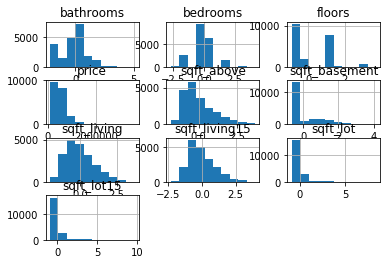

In [91]:
df_num.hist()


In [92]:

df_num['sqft_living_log'] = np.log(df_num['sqft_living'])
df_num['sqft_above_log'] = np.log(df_num['sqft_above'])
df_num['sqft_lot_log'] = np.log(df_num['sqft_lot'])
df_num['sqft_basement_log'] = np.log(df_num['sqft_basement'])
df_num['sqft_living15_log'] = np.log(df_num['sqft_living15'])
df_num['sqft_lot15_log'] = np.log(df_num['sqft_lot15'])
df_num['bathrooms'] = np.log(df_num['bathrooms'])
df_num['bedrooms'] = np.log(df_num['bedrooms'])
df_num['floors'] = np.log(df_num['floors'])

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
df_num.describe()


,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log
count,2.056800e+04,8248.000000,10533.000000,10301.000000,2.056800e+04,2.056800e+04,2.056800e+04,2.056800e+04,2.056800e+04,2.056800e+04,9066.000000,8168.000000,5389.000000,7058.000000,8606.000000,5924.000000
mean,5.185649e+05,-0.088340,-0.447865,-0.668766,1.401273e-17,3.821655e-18,-1.279293e-15,8.107856e-15,-5.581343e-17,-1.310590e-17,-0.569940,-0.468784,-1.022695,-0.127567,-0.505087,-1.242880
std,3.069806e+05,0.416998,0.660401,1.538188,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.189743,1.197917,1.717161,0.982555,1.129355,1.680785
min,7.800000e+04,-0.296844,-1.471346,-3.950074,-2.055674e+00,-8.869022e-01,-1.841026e+00,-6.626033e-01,-2.328013e+00,-9.382566e-01,-5.701755,-5.224892,-9.408793,-5.604643,-5.274664,-10.864418
25%,3.194875e+05,-0.296844,-0.555187,-0.057110,-7.570842e-01,-4.668061e-01,-7.493547e-01,-6.626033e-01,-7.361768e-01,-4.665852e-01,-1.149643,-1.072020,-2.032658,-0.564624,-1.123784,-2.423483
50%,4.450000e+05,-0.296844,-0.555187,-0.057110,-1.577350e-01,-2.342529e-01,-2.641675e-01,-6.626033e-01,-2.055646e-01,-1.998617e-01,-0.333634,-0.189342,-0.914842,0.116725,-0.271779,-1.254263
75%,6.298375e+05,-0.296844,-0.085216,-0.057110,6.039380e-01,1.508543e-02,5.579552e-01,6.168551e-01,5.747475e-01,4.349376e-02,0.283788,0.388265,0.239040,0.546576,0.326618,-0.039344
max,3.570000e+06,1.428494,1.619487,1.313778,3.700576e+00,8.433606e+00,3.711672e+00,4.141401e+00,3.969105e+00,9.698877e+00,1.308488,1.311482,2.132224,1.421034,1.378541,2.272010


In [94]:
df_combo = pd.concat([df_num, df_cat], axis=1)
df_combo.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,...,sqft_lot_log,sqft_basement_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,NaN,NaN,NaN,-1.044272,-0.405855,-0.749355,-0.662603,-0.954664,-0.399311,...,NaN,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,-0.550966,-0.530155,-0.520003
1,538000.0,NaN,-1.471346,-0.05711,0.691343,-0.256570,0.584910,0.303026,-0.408446,-0.184876,...,NaN,-1.193938,NaN,NaN,-0.292136,-0.636484,-0.076283,-0.550966,-0.665889,1.943098
2,180000.0,NaN,NaN,NaN,-1.556217,0.002051,-1.301929,-0.662603,1.198997,-0.139272,...,-6.18933,NaN,0.181486,NaN,-0.292136,-0.636484,-0.076283,-1.462066,-1.276692,1.871345
3,604000.0,-0.296844,0.233223,NaN,-0.070330,-0.466806,-0.924561,1.534203,-0.923452,-0.469388,...,NaN,0.428011,NaN,NaN,-0.292136,2.434405,-0.076283,-0.550966,-0.190820,-0.520003
4,510000.0,NaN,NaN,NaN,-0.419950,-0.177990,-0.075484,-0.662603,-0.236777,-0.199538,...,NaN,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,0.360134,0.555717,-0.520003


In [95]:
df_num_to_ols = pd.DataFrame.drop(df_num, columns=['sqft_lot'], inplace=True)

In [96]:
df_num_to_ols = pd.DataFrame.drop(df_num, columns=['sqft_basement_log'])


In [97]:
df_num_to_ols.head()


,price,bedrooms,bathrooms,floors,sqft_living,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log
0,221900.0,NaN,NaN,NaN,-1.044272,-0.749355,-0.662603,-0.954664,-0.399311,NaN,NaN,NaN,NaN,NaN
1,538000.0,NaN,-1.471346,-0.05711,0.691343,0.584910,0.303026,-0.408446,-0.184876,-0.369119,-0.536297,NaN,NaN,NaN
2,180000.0,NaN,NaN,NaN,-1.556217,-1.301929,-0.662603,1.198997,-0.139272,NaN,NaN,-6.18933,0.181486,NaN
3,604000.0,-0.296844,0.233223,NaN,-0.070330,-0.924561,1.534203,-0.923452,-0.469388,NaN,NaN,NaN,NaN,NaN
4,510000.0,NaN,NaN,NaN,-0.419950,-0.075484,-0.662603,-0.236777,-0.199538,NaN,NaN,NaN,NaN,NaN


In [98]:
df_combo = pd.concat([df_num_to_ols, df_cat], axis=1)
df_combo.dtypes

price                float64
bedrooms             float64
bathrooms            float64
floors               float64
sqft_living          float64
sqft_above           float64
sqft_basement        float64
sqft_living15        float64
sqft_lot15           float64
sqft_living_log      float64
sqft_above_log       float64
sqft_lot_log         float64
sqft_living15_log    float64
sqft_lot15_log       float64
view                 float64
condition            float64
waterfront           float64
grade                float64
yr_built             float64
yr_renovated         float64
dtype: object

In [99]:
outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'floors', 'sqft_living_log',
       'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'sqft_lot15_log',
       'view', 'condition', 'waterfront', 'grade', 'yr_built', 'yr_renovated']

In [100]:
# Some brief preprocessing
df_combo.columns = [col.replace(' ', '_') for col in df_combo.columns]
for col in x_cols:
   df_combo[col] = (df_combo[col] - df_combo[col].mean())/df_combo[col].std()
df_combo.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,NaN,NaN,NaN,-1.044272,-0.749355,-0.662603,-0.954664,-0.399311,NaN,NaN,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,-0.550966,-0.530155,-0.520003
1,538000.0,NaN,-1.549789,0.397647,0.691343,0.584910,0.303026,-0.408446,-0.184876,0.168794,-0.056359,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,-0.550966,-0.665889,1.943098
2,180000.0,NaN,NaN,NaN,-1.556217,-1.301929,-0.662603,1.198997,-0.139272,NaN,NaN,-3.008825,0.607934,NaN,-0.292136,-0.636484,-0.076283,-1.462066,-1.276692,1.871345
3,604000.0,-0.500012,1.031325,NaN,-0.070330,-0.924561,1.534203,-0.923452,-0.469388,NaN,NaN,NaN,NaN,NaN,-0.292136,2.434405,-0.076283,-0.550966,-0.190820,-0.520003
4,510000.0,NaN,NaN,NaN,-0.419950,-0.075484,-0.662603,-0.236777,-0.199538,NaN,NaN,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,0.360134,0.555717,-0.520003


In [104]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_combo).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     89.04
Date:                Fri, 14 Feb 2020   Prob (F-statistic):          4.00e-163
Time:                        13:32:41   Log-Likelihood:                -13826.
No. Observations:                 987   AIC:                         2.768e+04
Df Residuals:                     972   BIC:                         2.776e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.962e+05   2.25e+04     26.446      0.000    5.52e+05     6.4e+05
bedrooms          -6685.1671   1.06e+04     -0.631      0.528   -2.75e+04    1.41e+04
bathrooms          7.963e+04   1.07e+04      7.426      0.000    5.86e+04    1.01e+05
floors             4.976e+04   1.83e+04      2.714      0.007    1.38e+04    8.57e+04
sqft_living_log    1927.3006   2.35e+04      0.082      0.935   -4.41e+04     4.8e+04
sqft_above_log     1.534e+05   2.98e+04      5.155      0.000     9.5e+04    2.12e+05
sqft_lot_log      -3.427e+04   1.72e+04     -1.994      0.046    -6.8e+04    -536.270
sqft_living15_log  1.701e+04    1.7e+04      0.998      0.319   -1.64e+04    5.05e+04
sqft_lot15_log    -2190.2197   1.89e+04     -0.116      0.908   -3.92e+04    3.48e+04
view               4.216e+04   8515.812      4.951      0.000    2.55e+04    5.89e+04
condition          5.958e+04   1.29e+04      4.613      0.000    3.42e+04    8.49e+04
waterfront         6.278e+04   6341.841      9.900      0.000    5.03e+04    7.52e+04
grade              1.663e+05   1.42e+04     11.716      0.000    1.38e+05    1.94e+05
yr_built          -2.458e+05   2.26e+04    -10.883      0.000    -2.9e+05   -2.01e+05
yr_renovated       2.317e+04   9545.863      2.427      0.015    4438.695    4.19e+04
==============================================================================
Omnibus:                      299.326   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1113.166
Skew:                           1.418   Prob(JB):                    1.90e-242
Kurtosis:                       7.362   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:

#dropping floors and sqft_lot_log

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living_log',
       'sqft_above_log',  'sqft_living15_log', 'sqft_lot15_log',
       'view', 'condition', 'waterfront', 'grade', 'yr_built', 'yr_renovated']

In [106]:
# Some brief preprocessing
df_combo.columns = [col.replace(' ', '_') for col in df_combo.columns]
for col in x_cols:
   df_combo[col] = (df_combo[col] - df_combo[col].mean())/df_combo[col].std()
df_combo.head()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,NaN,NaN,NaN,-1.044272,-0.749355,-0.662603,-0.954664,-0.399311,NaN,NaN,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,-0.550966,-0.530155,-0.520003
1,538000.0,NaN,-1.549789,0.397647,0.691343,0.584910,0.303026,-0.408446,-0.184876,0.168794,-0.056359,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,-0.550966,-0.665889,1.943098
2,180000.0,NaN,NaN,NaN,-1.556217,-1.301929,-0.662603,1.198997,-0.139272,NaN,NaN,-3.008825,0.607934,NaN,-0.292136,-0.636484,-0.076283,-1.462066,-1.276692,1.871345
3,604000.0,-0.500012,1.031325,NaN,-0.070330,-0.924561,1.534203,-0.923452,-0.469388,NaN,NaN,NaN,NaN,NaN,-0.292136,2.434405,-0.076283,-0.550966,-0.190820,-0.520003
4,510000.0,NaN,NaN,NaN,-0.419950,-0.075484,-0.662603,-0.236777,-0.199538,NaN,NaN,NaN,NaN,NaN,-0.292136,-0.636484,-0.076283,0.360134,0.555717,-0.520003


In [108]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_combo).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     133.6
Date:                Fri, 14 Feb 2020   Prob (F-statistic):          9.85e-227
Time:                        13:33:18   Log-Likelihood:                -21303.
No. Observations:                1516   AIC:                         4.263e+04
Df Residuals:                    1503   BIC:                         4.270e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6.297e+05    1.6e+04     39.349      0.000    5.98e+05    6.61e+05
bedrooms          -9556.5753   8509.759     -1.123      0.262   -2.62e+04    7135.689
bathrooms          7.187e+04   8858.612      8.113      0.000    5.45e+04    8.92e+04
sqft_living_log    6.664e+04   1.63e+04      4.079      0.000    3.46e+04    9.87e+04
sqft_above_log     6.148e+04   1.18e+04      5.190      0.000    3.82e+04    8.47e+04
sqft_living15_log  1.364e+04   1.32e+04      1.031      0.303   -1.23e+04    3.96e+04
sqft_lot15_log    -2.156e+04   8682.770     -2.483      0.013   -3.86e+04   -4525.603
view               2.747e+04   6456.934      4.255      0.000    1.48e+04    4.01e+04
condition          4.283e+04   1.04e+04      4.116      0.000    2.24e+04    6.32e+04
waterfront         7.151e+04   5748.477     12.441      0.000    6.02e+04    8.28e+04
grade              1.777e+05   1.17e+04     15.226      0.000    1.55e+05    2.01e+05
yr_built          -2.248e+05   1.78e+04    -12.625      0.000    -2.6e+05    -1.9e+05
yr_renovated       1.611e+04   8093.328      1.990      0.047     230.037     3.2e+04
==============================================================================
Omnibus:                      401.932   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1205.598
Skew:                           1.333   Prob(JB):                    1.61e-262
Kurtosis:                       6.460   Cond. No.                         6.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
#dropping floors and sqft_lot_log

y = pd.DataFrame(df_combo, columns=['price'])

X = df_combo[['bedrooms', 'bathrooms', 'sqft_living_log',
       'sqft_above_log',  'sqft_living15_log', 'sqft_lot15_log',
       'view', 'condition', 'waterfront', 'grade', 'yr_built', 'yr_renovated']]

In [110]:
from sklearn.model_selection import train_test_split


In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [112]:
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))


15426 5142 15426 5142


In [113]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [115]:
linreg.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').